## Question 3: What genetic alterations could improve your engineered cardiomyocytes?

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co

which: no R in (/home/ec2-user/venv/celloracle/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/ec2-user/.local/bin:/home/ec2-user/bin)


In [2]:
# Do setup
co.__version__

plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

# Make folders to save plots and links
im_folder = "co_figures"
link_folder = "co_links"

os.makedirs(im_folder, exist_ok=True)
os.makedirs(link_folder, exist_ok=True)

## Data preprocessing

1. Variable gene selection and normalization.

2. Log transformation. 

3. Cell clustering.

4. Dimensional reduction.

In [16]:
def preprocess_pipeline(adata,plot=False): 
    """
    This function preprocessing the scRNA-seq data
    
    """

    # adata.var['mt']= adata.var_names.str.startswith(("mt-"))
    # adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    # Filter out doublets
    thresh = np.percentile(adata.obs['total_counts'],95)
    adata = adata[adata.obs['total_counts'] < thresh, :]
    # Filter out low quality cells 
    # adata = adata[adata.obs['pct_counts_mt'] < 5, :]
    # adata = adata[adata.obs['pct_counts_ribo'] < 35, :]
    # adata = adata[adata.obs['total_counts'] > 10000, :]
    ################################################################################
    # 1. filter out undetected genes that are expressed in less than 5 cells 
    sc.pp.filter_genes(adata, min_cells=5)
    ################################################################################
    # 2. Normalize gene expression matrix with total UMI count per cell
    sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
    ################################################################################
    # 3. Identification of highly variable genes
    # Select top 2000 highly-variable genes
    filter_result = sc.pp.filter_genes_dispersion(adata.X, n_top_genes=3000,log=False)
    # Subset the genes
    adata = adata[:, filter_result.gene_subset]
    # Renormalize after filtering
    sc.pp.normalize_per_cell(adata)
    ################################################################################
    # 4. Log Transform
    # keep raw cont data before log transformation
    adata.raw = adata
    adata.layers["raw_count"] = adata.raw.X.copy()
    # Log transformation and scaling
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    ################################################################################
    # 5. PCA and neighbor calculations
    sc.tl.pca(adata, svd_solver='arpack')
    # Diffusion map
    sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
    sc.tl.diffmap(adata)
    # Calculate neihbors again based on diffusionmap
    sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
    ################################################################################
    # 6. cell clustering 
    sc.tl.louvain(adata, resolution=0.8)
    ################################################################################
    # 7. Dimensionality reduction using PAGA and force-directed graphs
    # PAGA graph construction
    sc.tl.paga(adata, groups='louvain')
    plt.rcParams["figure.figsize"] = [6, 4.5]
    sc.pl.paga(adata)
    sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
    sc.pl.draw_graph(adata, color='louvain', legend_loc='on data')
    adata.write_h5ad("preprocessed_hIPSC_CM_orlova_GSM4443382.h5ad")
    return adata

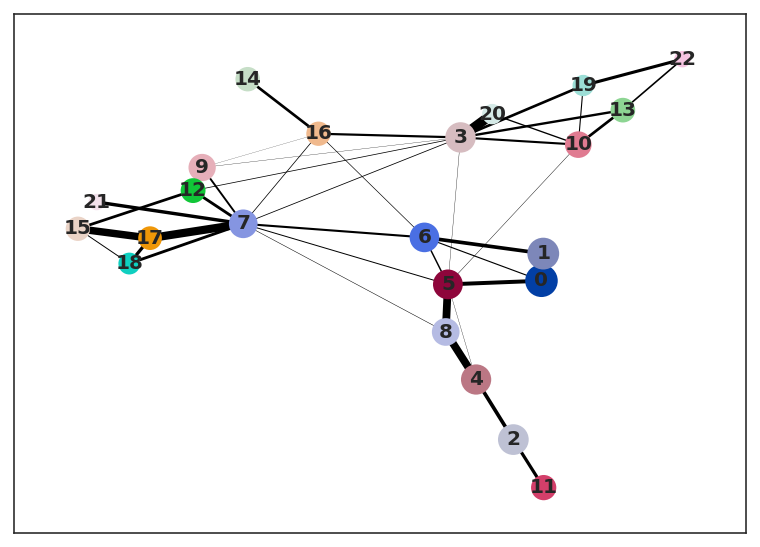

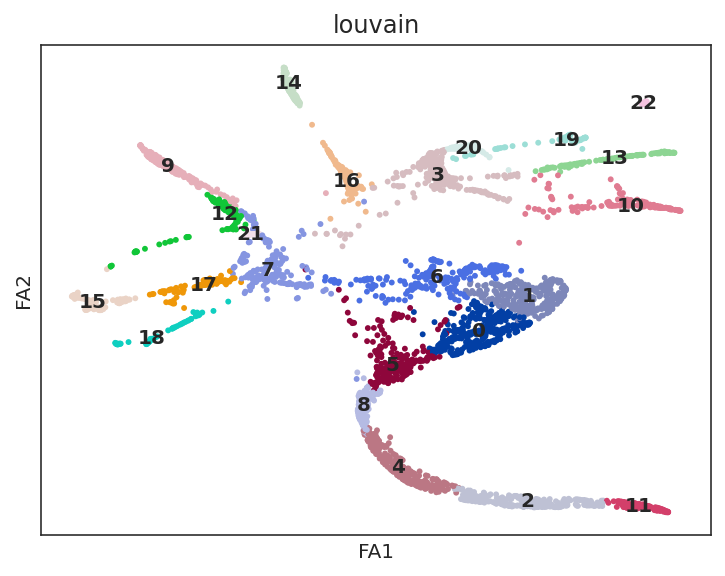

In [17]:
raw_adata = sc.read_h5ad("hIPSC_CM_orlova_GSM4443382.h5ad")
adata = preprocess_pipeline(adata=raw_adata)

In [18]:
adata

AnnData object with n_obs × n_vars = 3467 × 2999
    obs: 'n_genes_by_counts', 'total_counts', 'n_counts_all', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors', 'draw_graph'
    obsm: 'X_pca', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

## Construct GRN model based on default Base-GRN
In order to validate the effectiveness of CellOracle, we will train an oracle on the **Giacomelli** data.

We would like to turn everything in this section into a single callable function, taking the following inputs:


*   `h5ad` to preprocessed h5ad (QC, clustering, projection) *required*
*   `clusters` used for CellOracle regression *default: louvain*
*   `embedding` used for representation *default: X_draw_graph_fa*
*   `oracle_name` used for saving the oracle/links *default: oracle*

It will have no output, but will save 2 items in the folder it is run in:
*   `{oracle_name}.celloracle.oracle`
*   `{oracle_name}.celloracle.links`


In [21]:
def creat_grn(h5ad = "preprocessed_hIPSC_CM_orlova_GSM4443382.h5ad", #put file directory here
              clusters = "louvain", #change if needed
              embedding = "X_draw_graph_fa", #change if needed
              oracle_name = "human_cm" ):
    '''
    Calculate Pearson correlation of 2 anndata matrices
    
    Input:
    --------
        h5ad: to preprocessed h5ad (QC, clustering, projection) *required*
        clusters: used for CellOracle regression *default: louvain*
        embedding: used for representation *default: X_draw_graph_fa*
        oracle_name: used for saving the oracle/links *default: oracle*
    
    Output:
    --------
         None
    '''
    
    adata = sc.read_h5ad(h5ad)
    gene_in(list(adata.var.index))
    # In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
    adata.X = adata.layers["raw_count"].copy()
    #load GRN and create oracle
    base_GRN = co.data.load_human_promoter_base_GRN()
    oracle = co.Oracle()
    # Instantiate Oracle object.
    oracle.import_anndata_as_raw_count(adata=adata,
                                       cluster_column_name=clusters,
                                       embedding_name=embedding)
    oracle.import_TF_data(TF_info_matrix=base_GRN)
    # Perform PCA
    oracle.perform_PCA()
    # Select important PCs
    plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
    n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
    plt.axvline(n_comps, c="k")
    print(n_comps)
    n_comps = min(n_comps, 50)
    n_cell = oracle.adata.shape[0]
    k = int(0.025*n_cell)
    print(f"For {n_cell} cells, default k is :{k}")

    oracle.knn_imputation(n_pca_dims=n_comps,
                          k=k,
                          balanced=True,
                          b_sight=k*8,
                          b_maxl=k*4,
                          n_jobs=8) #can change this
    #save
    oracle.to_hdf5(file_path=f"{oracle_name}.celloracle.oracle")
    links = oracle.get_links(cluster_name_for_GRN_unit=clusters,
                         alpha=10,
                         verbose_level=10)
    links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
    links.get_network_score()
    #save filtered links
    for cluster in links.filtered_links.keys():
        links.links_dict[cluster].to_csv(f"{link_folder}/GRN_{cluster}.csv")
    #save these as well.
    links.to_hdf5(file_path=f"{oracle_name}.celloracle.links")


Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
100
For 3467 cells, default k is :86


  0%|          | 0/23 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 1...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 10...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 11...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 12...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 13...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 14...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 15...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 16...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 17...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 18...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 19...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 2...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 20...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 21...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 22...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 3...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 4...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 5...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 6...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 7...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 8...


  0%|          | 0/2609 [00:00<?, ?it/s]

inferring GRN for 9...


  0%|          | 0/2609 [00:00<?, ?it/s]

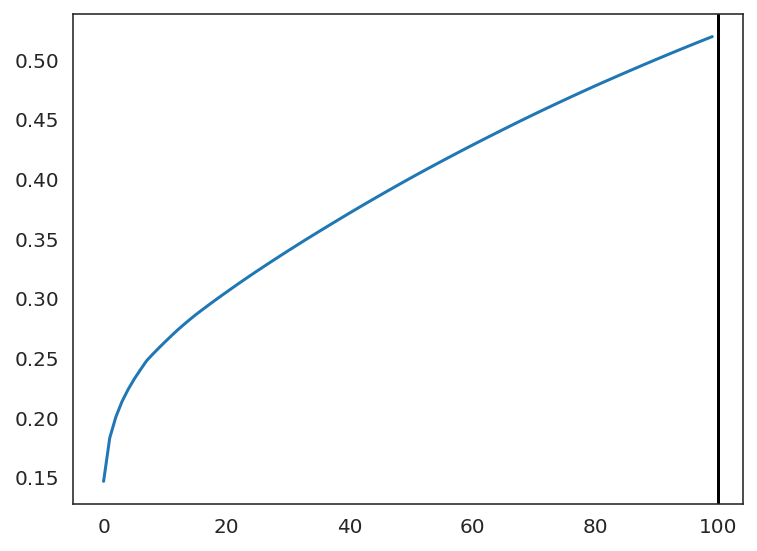

In [22]:
creat_grn()

## Gene network analysis

1. Visualize top n-th genes with high scores in different clusters.

2. By comparing network scores between earlier cluster and late cluster, we can analyze differences in GRN structure. Look at the different genes for the earliest and latest clusters. We would like to improve on the effect by *repressing* the TFs most prominent in early cells and *expressing* the TFs most prominent in late cells. Pick, say, the top 20 differentially linked genes. These will be the shifts we test on the cardiomyocyte oracle.

3. Focus on how a gene’s network score changes during the differentiation. Here we choose Chd2,Zeb1 and Prdm16 as our target genes.


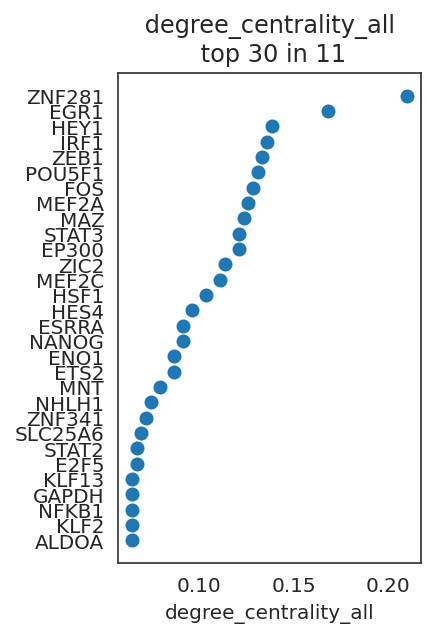

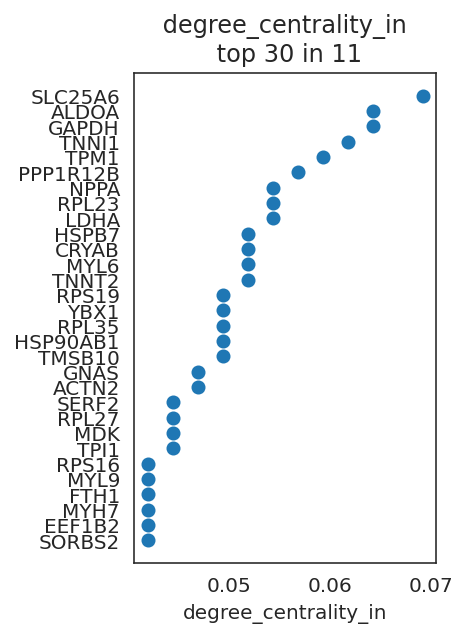

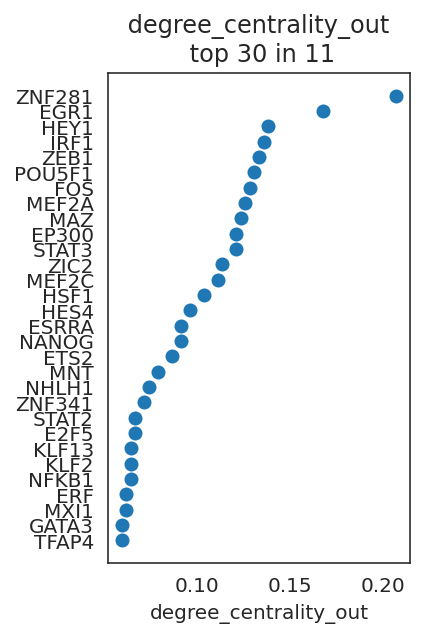

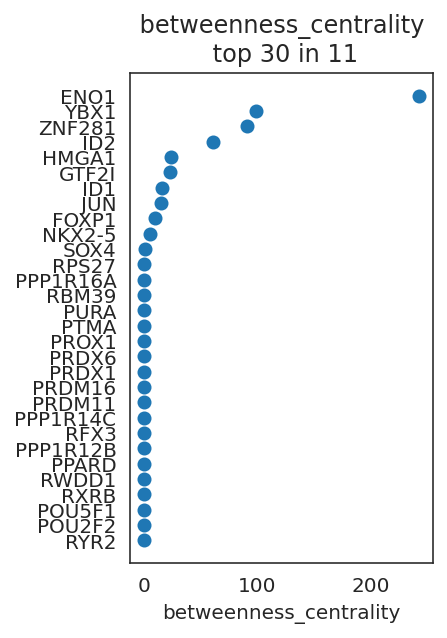

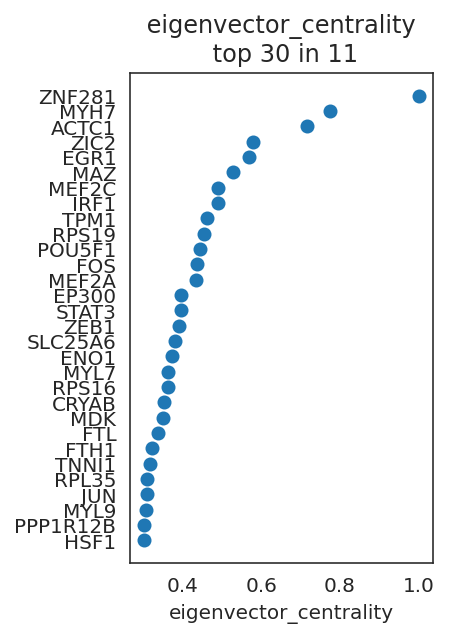

In [24]:
# Visualize top n-th genes with high scores.
links = co.load_hdf5("human_cm.celloracle.links")
links.plot_scores_as_rank(cluster="11", n_gene=30, save=f"ranked_score")

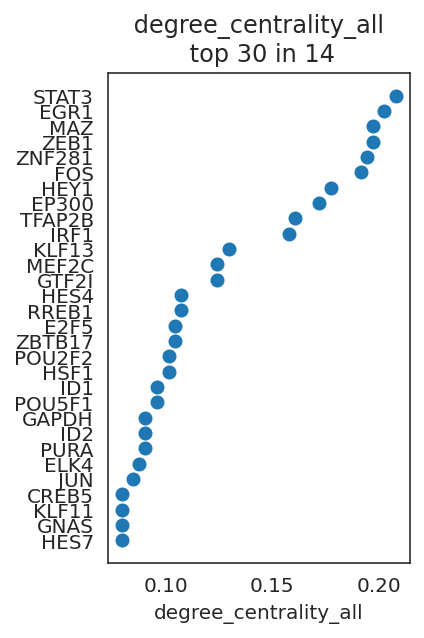

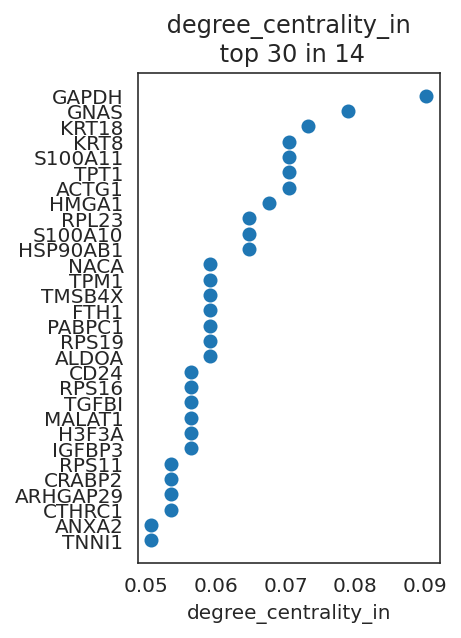

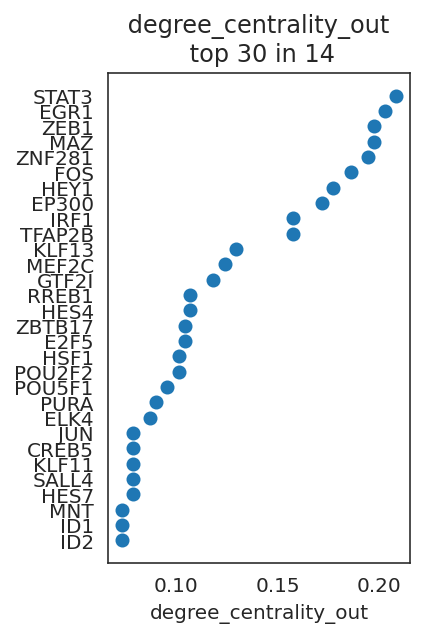

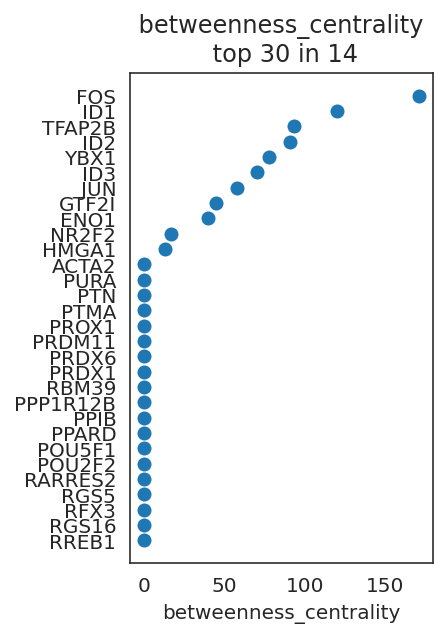

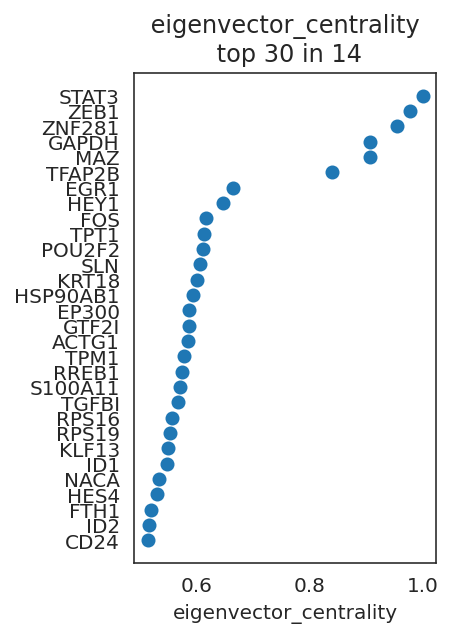

In [27]:
# Visualize top n-th genes with high scores.
links = co.load_hdf5("human_cm.celloracle.links")
links.plot_scores_as_rank(cluster="14", n_gene=30, save=f"ranked_score")

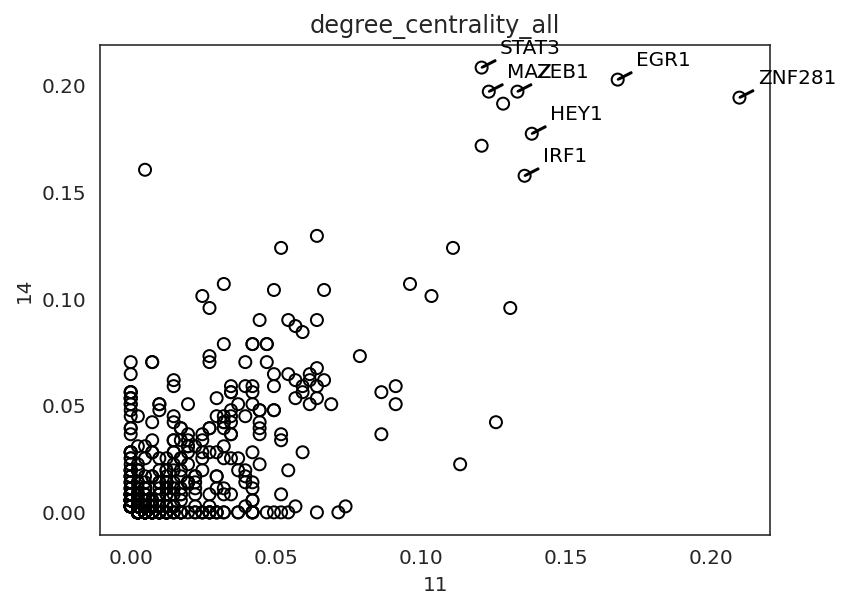

In [28]:
early_cluster = '11' #put Kannan early cluster name here
late_cluster = '14' #put Kannan late cluster name here
value = "degree_centrality_all"
links.plot_score_comparison_2D(value,
                               early_cluster,
                               late_cluster,
                               percentile=99,
                               annot_shifts=None,
                               save=f"{early_cluster}_{late_cluster}.png",
                               plt_show=True,
                               interactive=False)

ZNF281


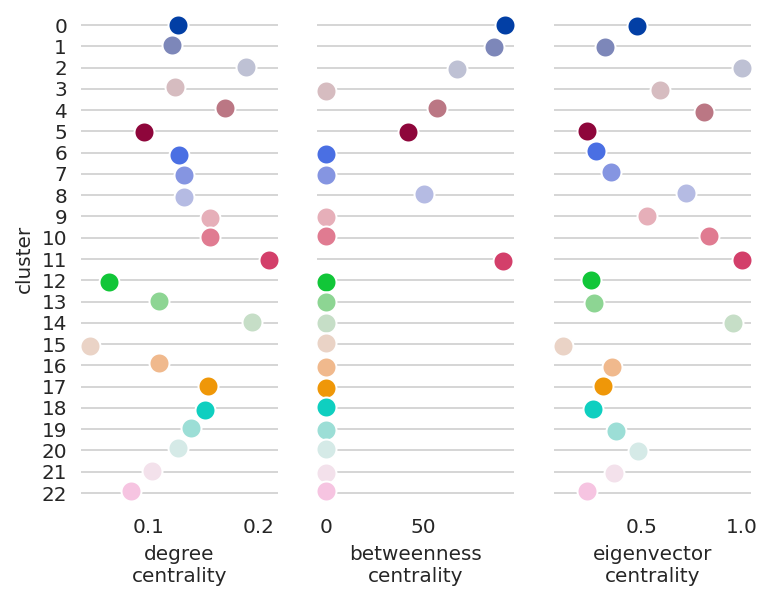

In [29]:
# Visualize ZNF281 network score dynamics
links.plot_score_per_cluster(goi="ZNF281", save=f"network_score_ZNF281/")

STAT3


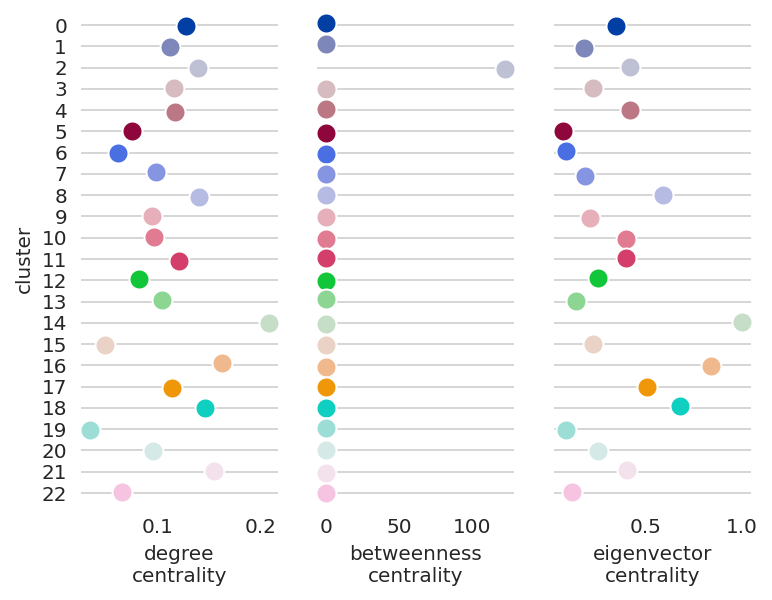

In [30]:
# Visualize STAT3 network score dynamics
links.plot_score_per_cluster(goi="STAT3", save=f"network_score_STAT3/")

## Run in silico TF perturbations with the GRN models
1. Use the GRN model to simulate cell identity shifts in response to TF perturbation. In this part we create a **Prdm16-KO** model.

2. Compare simulation vectors with developmental vectors. First, we will calculate a pseudotime gradient vector field to recapitulate the developmental flow. Then, we will compare the CellOracle TF perturbation vector field with the developmental vector field by calculating the inner product scores. 


In [31]:
oracle = co.load_hdf5("human_cm.celloracle.oracle")
links = co.load_hdf5("human_cm.celloracle.links")

In [32]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in 0


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1394 genes
calculating GRN in 1


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1384 genes
calculating GRN in 10


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1412 genes
calculating GRN in 11


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1388 genes
calculating GRN in 12


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1282 genes
calculating GRN in 13


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1412 genes
calculating GRN in 14


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1347 genes
calculating GRN in 15


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1230 genes
calculating GRN in 16


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1249 genes
calculating GRN in 17


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1255 genes
calculating GRN in 18


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1283 genes
calculating GRN in 19


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1345 genes
calculating GRN in 2


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1400 genes
calculating GRN in 20


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1474 genes
calculating GRN in 21


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1350 genes
calculating GRN in 22


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1478 genes
calculating GRN in 3


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1417 genes
calculating GRN in 4


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1378 genes
calculating GRN in 5


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1349 genes
calculating GRN in 6


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1384 genes
calculating GRN in 7


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1133 genes
calculating GRN in 8


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1358 genes
calculating GRN in 9


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1333 genes


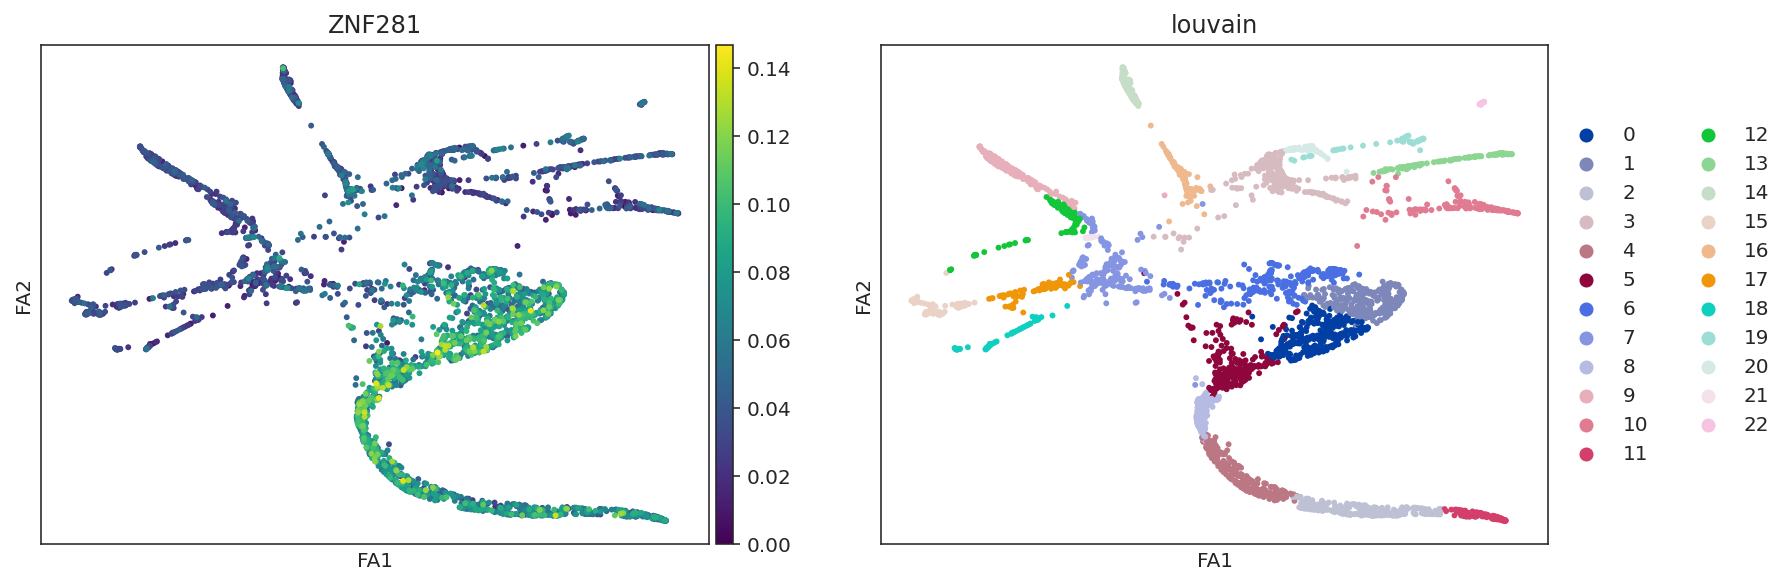

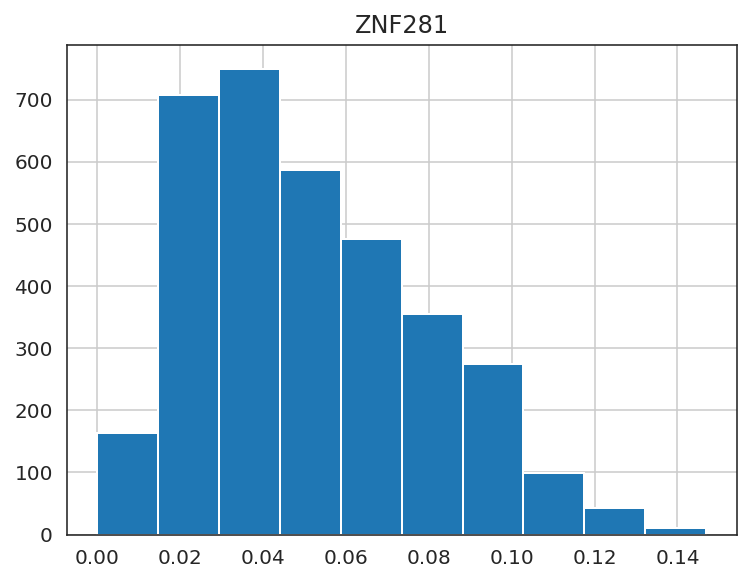

In [33]:
goi = "ZNF281"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [36]:
gene = "ZNF281"
oracle.simulate_shift(perturb_condition={gene: 0.0},
                      n_propagation=3)
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)
# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

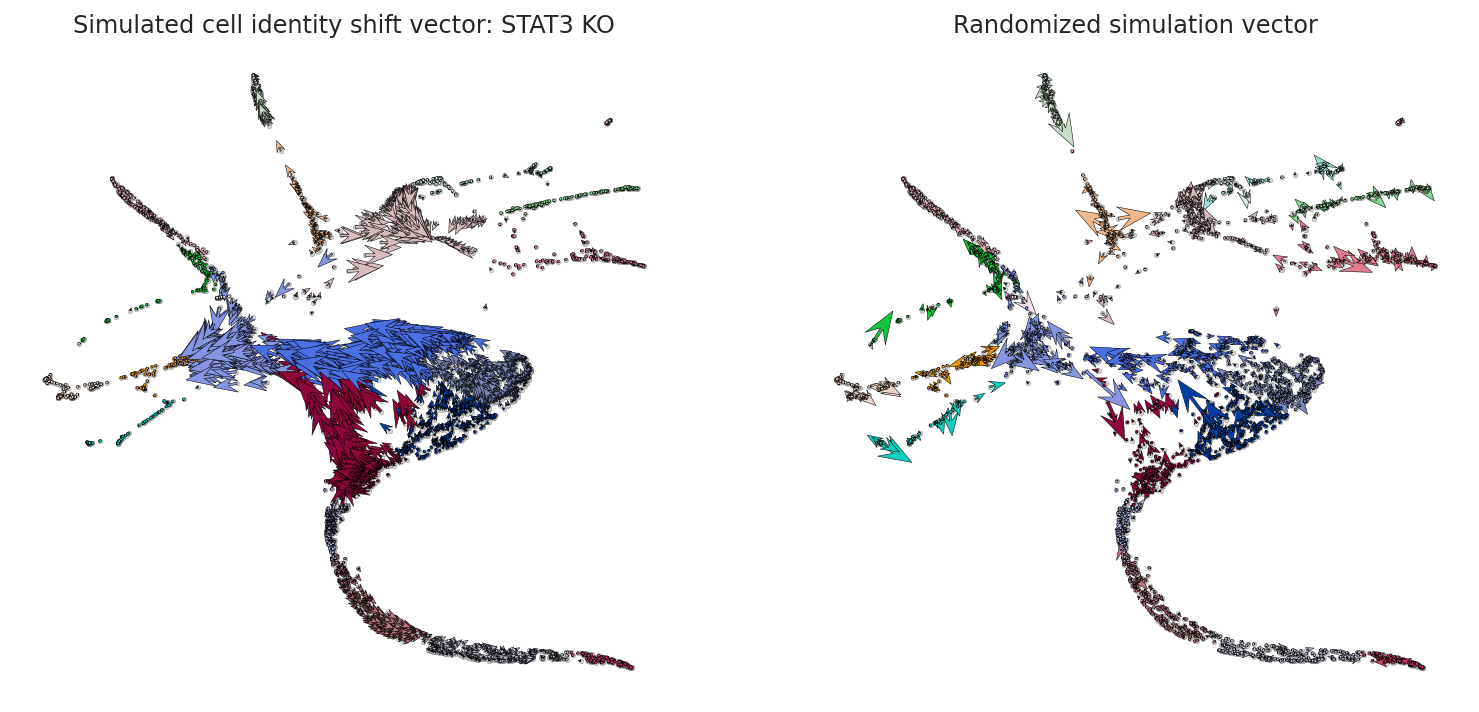

In [37]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])
oracle.embedding = oracle.adata.obsm["X_draw_graph_fa"]

scale = 10
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [38]:
# n_grid = 40 is a good starting value.
n_grid = 40 
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

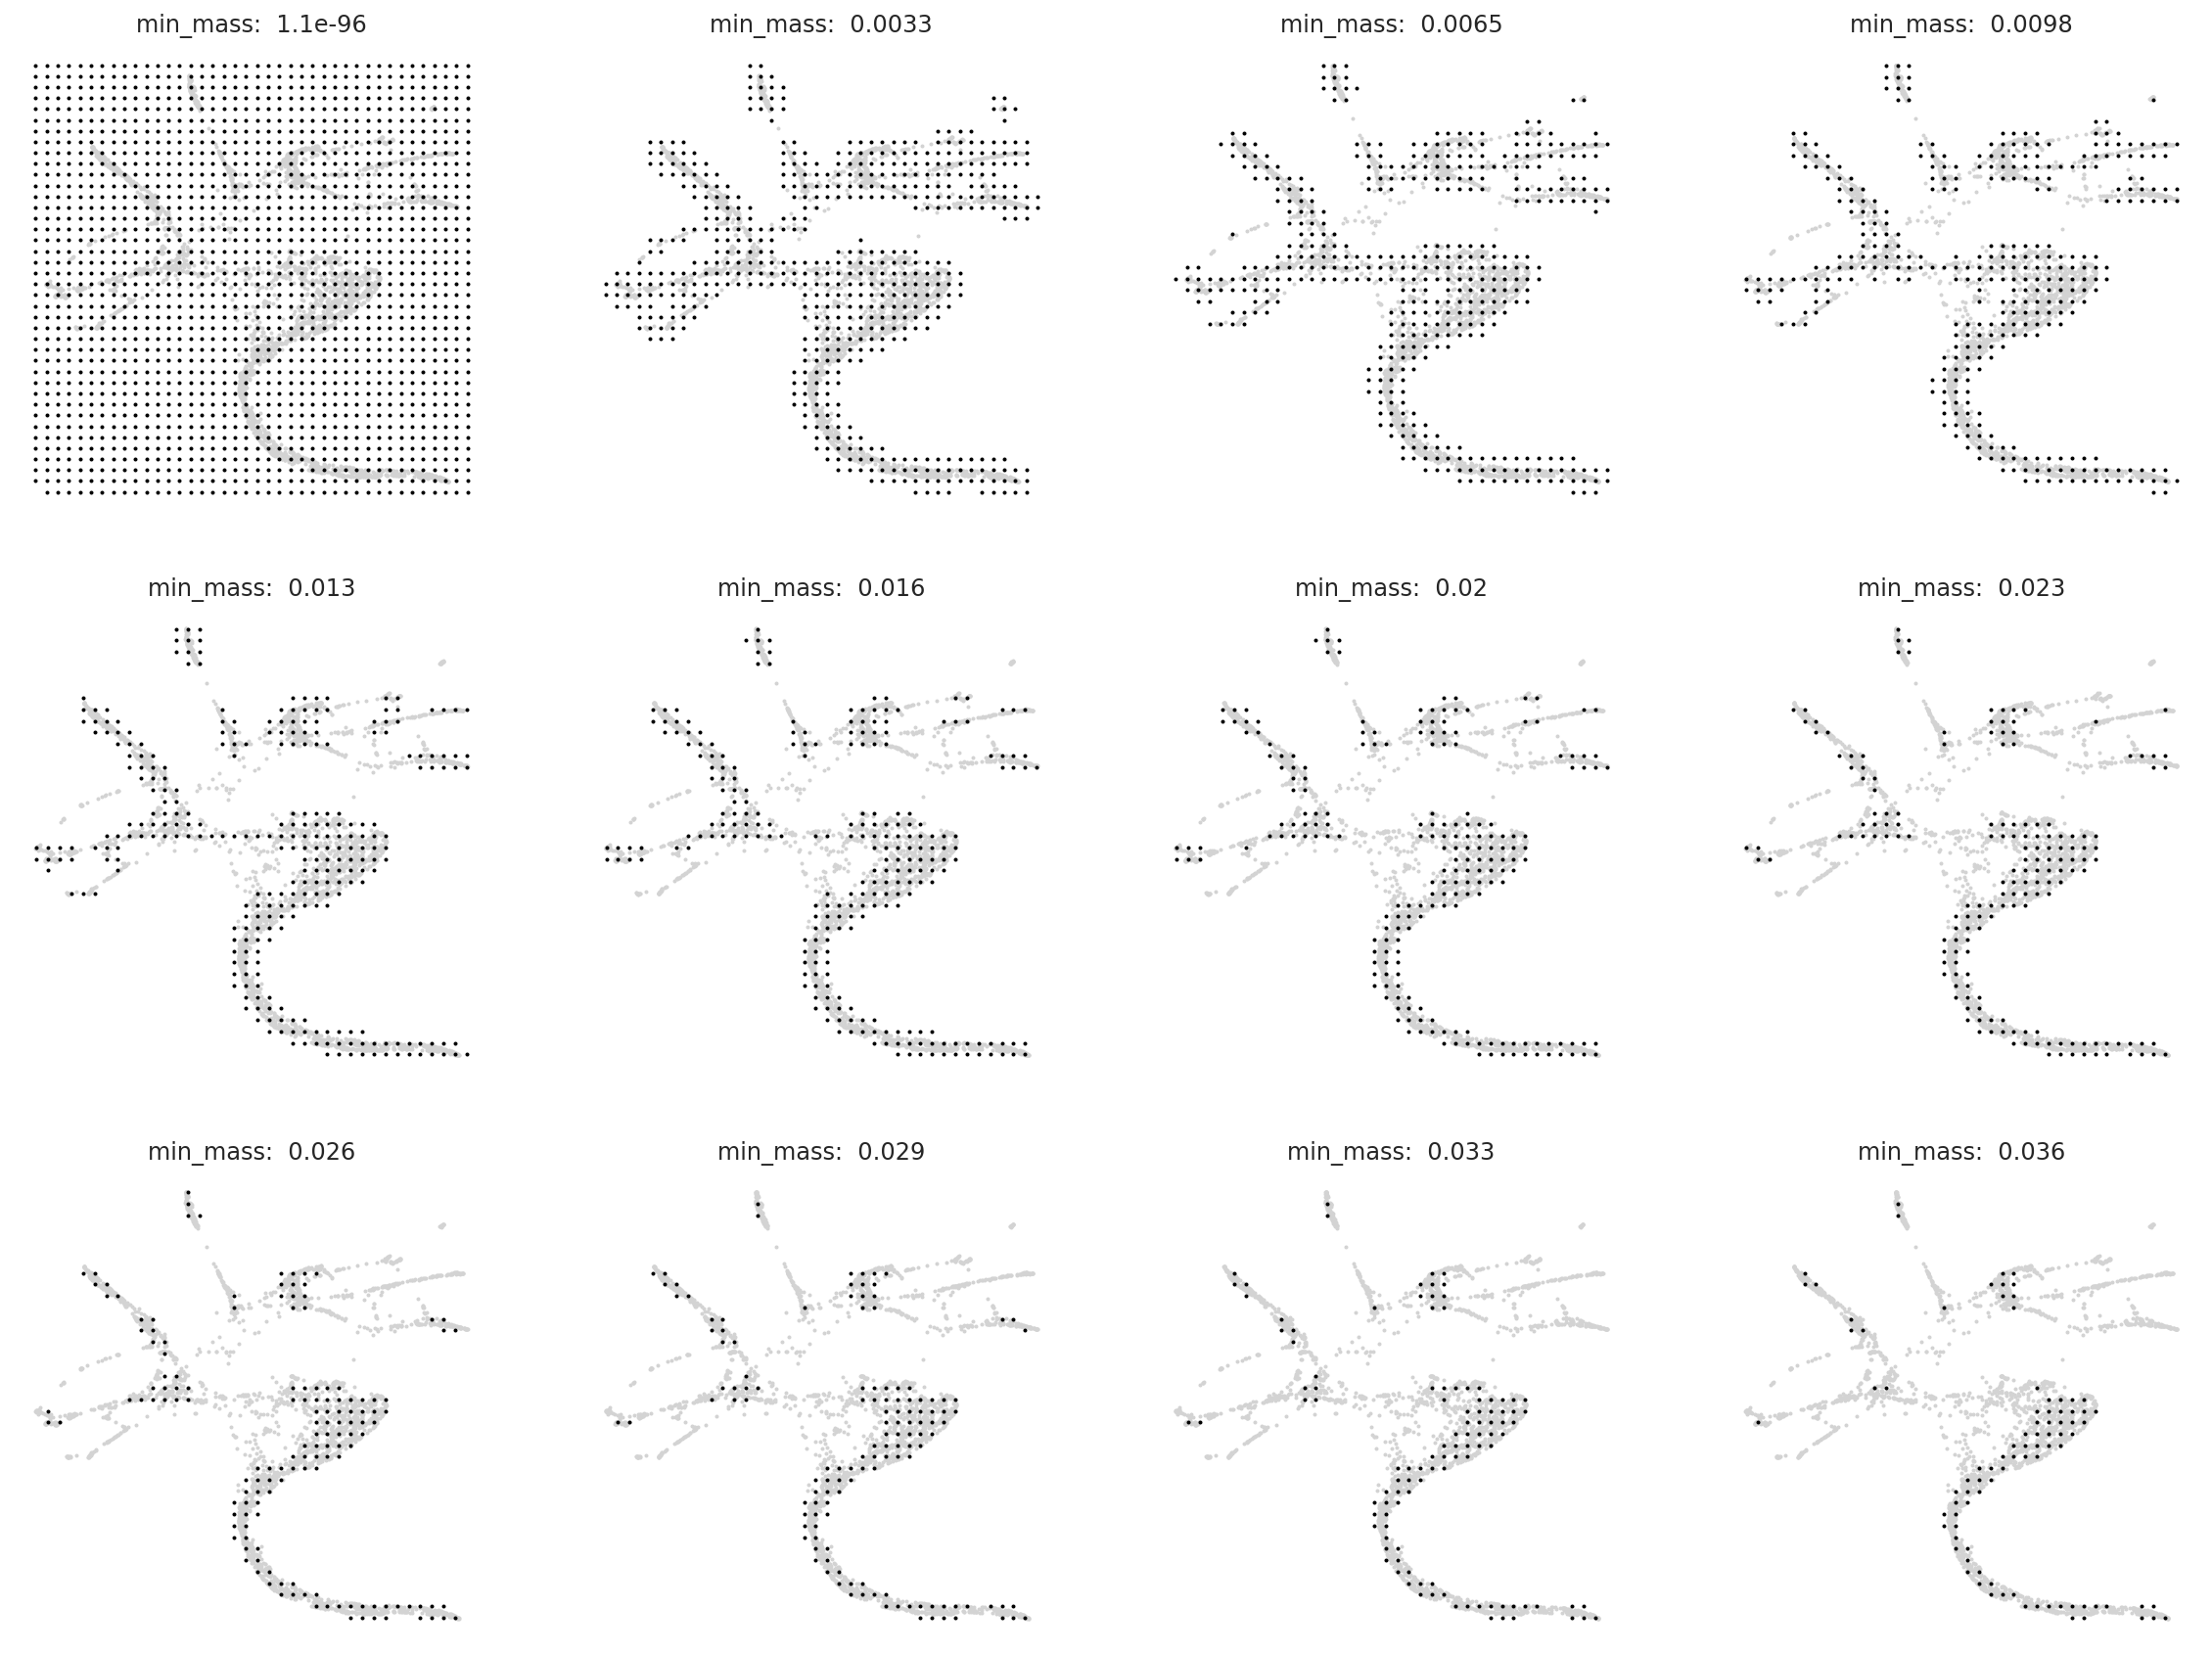

In [39]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

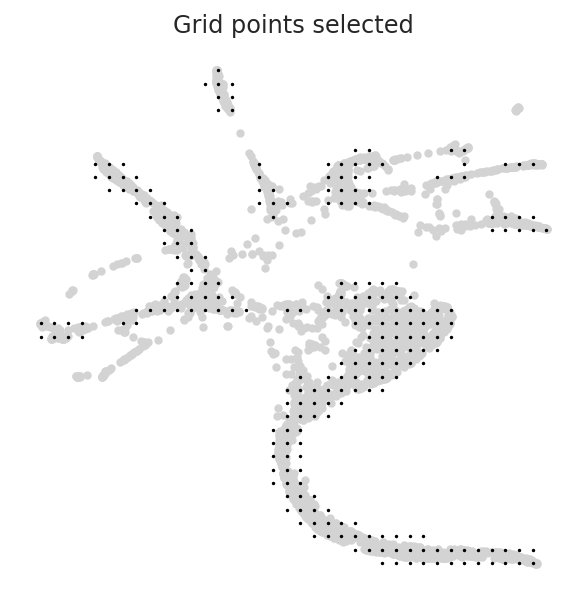

In [40]:
min_mass = 0.016
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

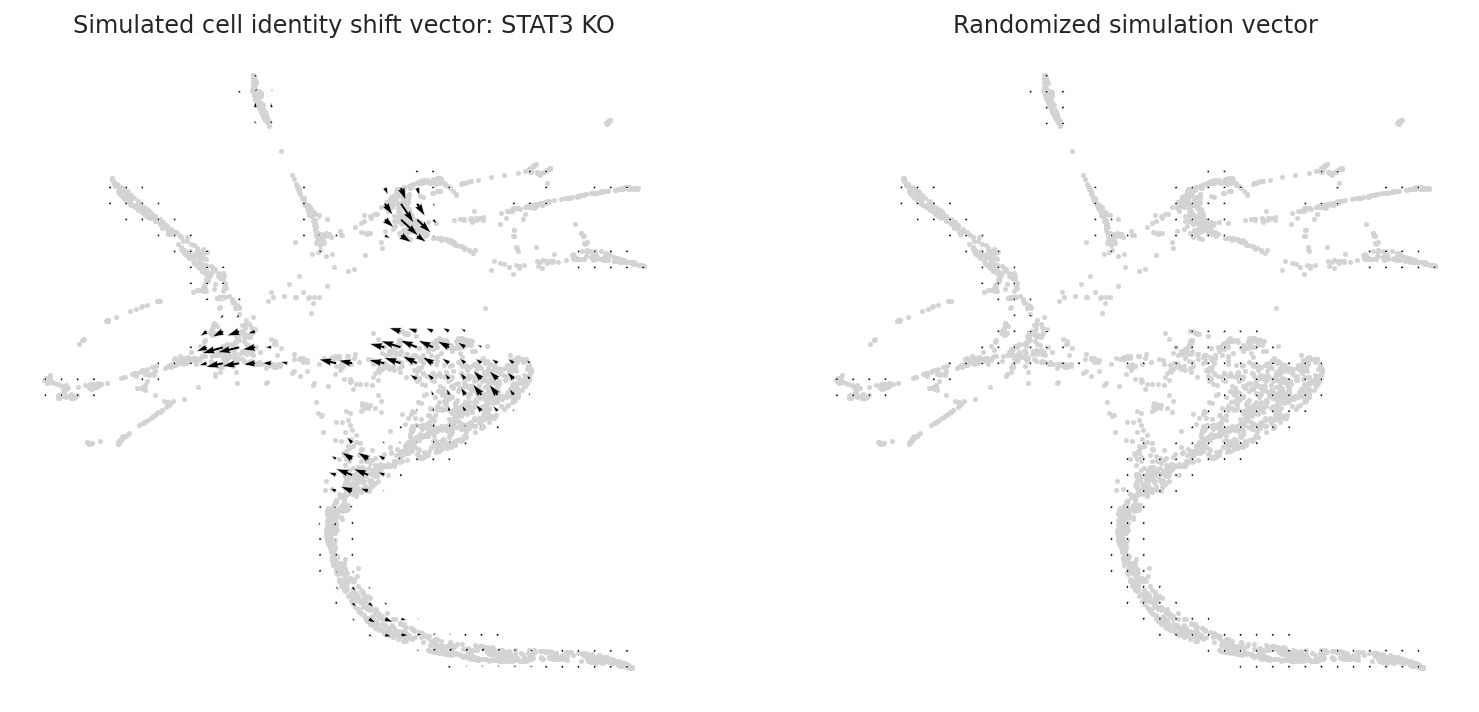

In [41]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 0.5
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

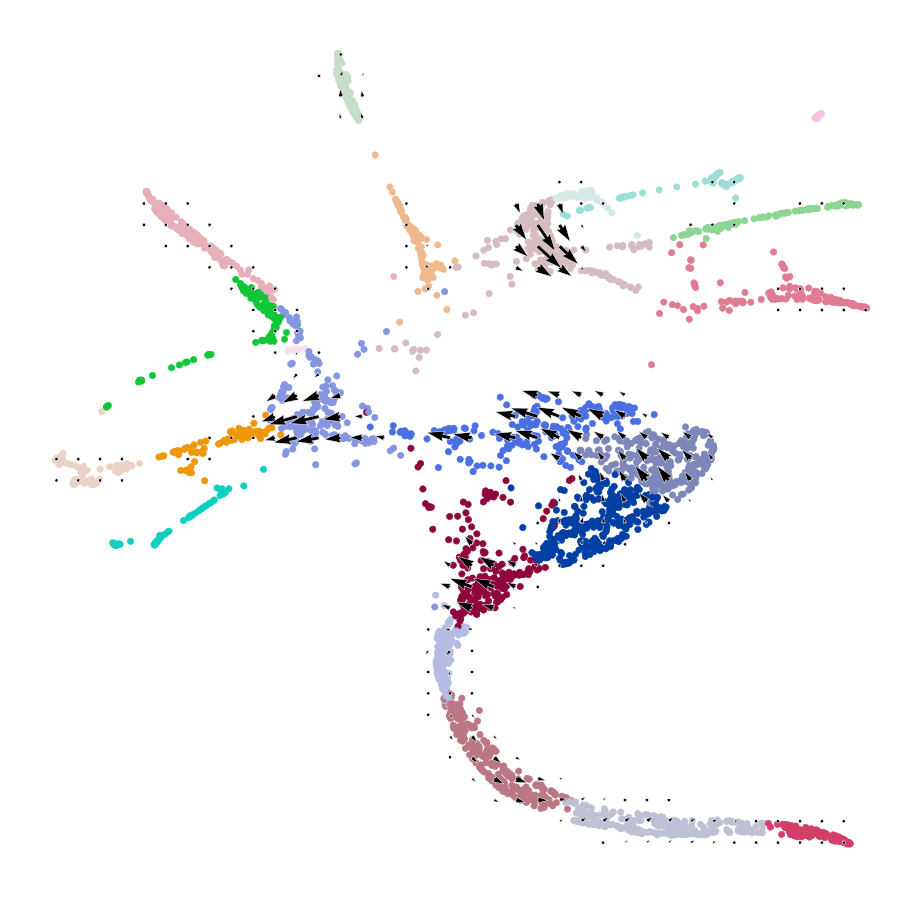

In [42]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [45]:
# save the model before pseudotime calculator
oracle.to_hdf5(file_path=f"{'intermedia_data_human'}.celloracle.oracle")

In [46]:
from celloracle.applications import Pseudotime_calculator

In [47]:
# Instantiate pseudotime object using oracle object.
oracle = co.load_hdf5("intermedia_data_human.celloracle.oracle")
oracle.embedding_name = 'X_draw_graph_fa'
pt = Pseudotime_calculator(oracle_object=oracle)
print("Clustering name: ", pt.cluster_column_name)
print("Cluster list", pt.cluster_list)

Clustering name:  louvain
Cluster list ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9']


In [60]:
# Here, clusters can be classified into either MEP lineage or GMP lineage

clusters_ear = ['11','2','4','8','5','0','1','6']
clusters_lat1 = ['7','21','12', '9','17', '18','15']
clusters_lat2 = ['10',  '13', '14', '16',  '19', '20',  '22', '3']

# Make a dictionary
lineage_dictionary = {"Lineage_E": clusters_ear  ,
                      "Lineage_L1": clusters_lat1,
                      "Lineage_L2": clusters_lat2}

# Input lineage information into pseudotime object
pt.set_lineage(lineage_dictionary=lineage_dictionary)

In [52]:
adata.obs

n_genes_by_counts  total_counts  n_counts_all    n_counts  \
AAACCTGAGAAGGTTT-1                503        1006.0        1004.0  493.583679   
AAACCTGAGCATCATC-1                510        1016.0        1016.0  478.824799   
AAACCTGGTCGTGGCT-1                369         826.0         826.0  262.220367   
AAACCTGGTTTCGCTC-1                657        1227.0        1223.0  519.247803   
AAACGGGAGCCGCCTA-1                318         555.0         555.0  455.643219   
...                               ...           ...           ...         ...   
TTTGGTTTCTCTGAGA-1                461         970.0         969.0  452.897827   
TTTGGTTTCTGTGCAA-1                683        1308.0        1304.0  535.693237   
TTTGTCAGTCTCCACT-1                621        1409.0        1403.0  398.476135   
TTTGTCATCCTACAGA-1                537        1065.0        1064.0  472.144714   
TTTGTCATCTTAACCT-1                932        2193.0        2190.0  336.575317   

                   louvain  
AAACCTGAGAAGGTTT-1       6  
AAACCTGAGCATCATC-1       2  
AAACCTGGTCGTGGCT-1       3  
AAACCTGGTTTCGCTC-1       0  
AAACGGGAGCCGCCTA-1       8  
...                    ...  
TTTGGTTTCTCTGAGA-1      11  
TTTGGTTTCTGTGCAA-1       0  
TTTGTCAGTCTCCACT-1      14  
TTTGTCATCCTACAGA-1       2  
TTTGTCATCTTAACCT-1       9  

[3467 rows x 5 columns]

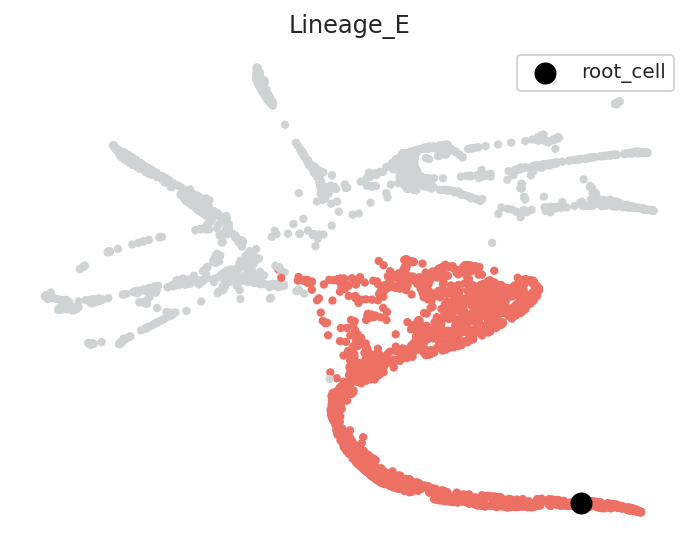

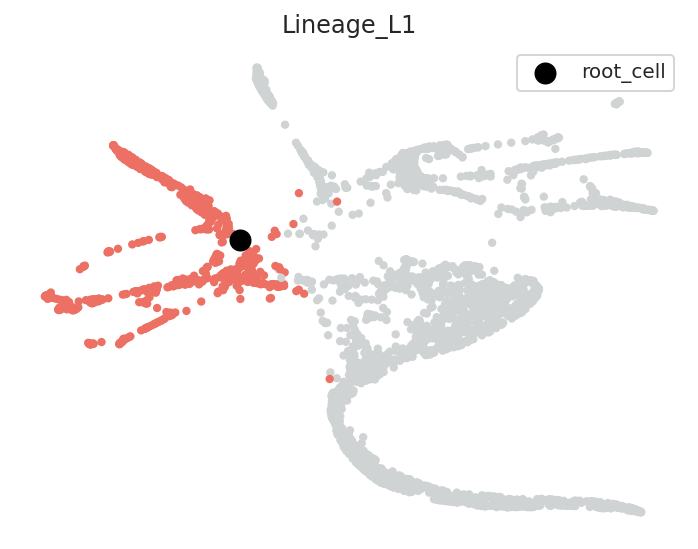

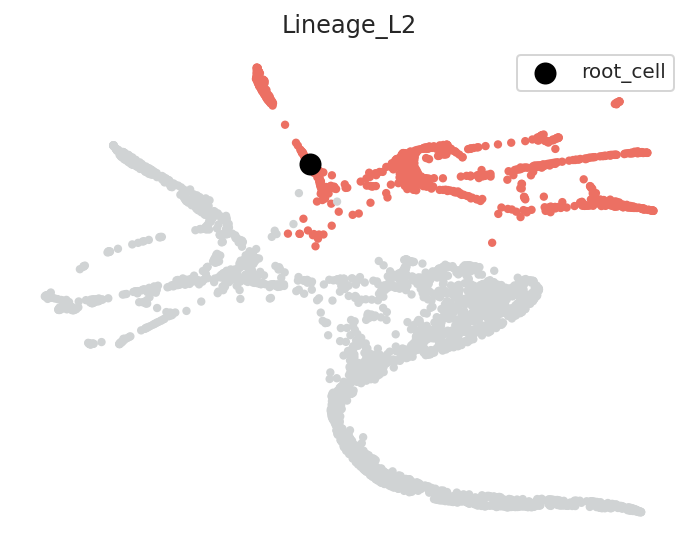

In [61]:
root_cells = {"Lineage_E": oracle.adata.obs.index[np.flatnonzero(oracle.adata.obs['louvain'] == '11')[0]],
              "Lineage_L1": oracle.adata.obs.index[np.flatnonzero(oracle.adata.obs['louvain'] == '7')[0]],
              "Lineage_L2": oracle.adata.obs.index[np.flatnonzero(oracle.adata.obs['louvain'] == '16')[0]],}
pt.set_root_cells(root_cells=root_cells)
# Check root cell and lineage
pt.plot_root_cells()

In [62]:
"X_diffmap" in pt.adata.obsm

True

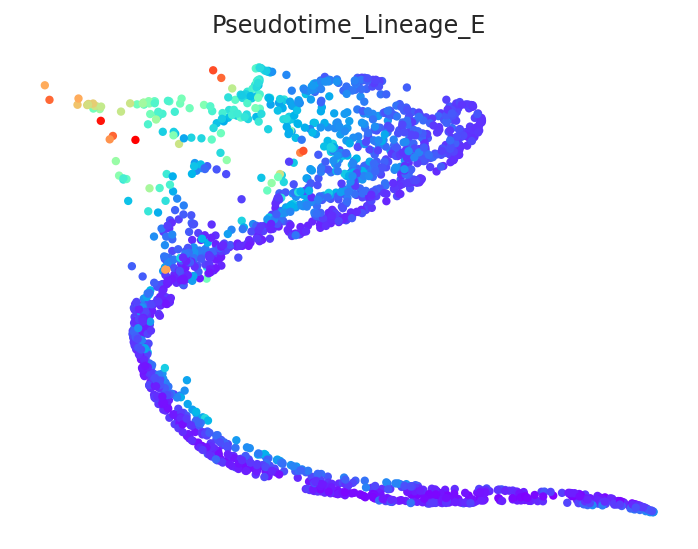

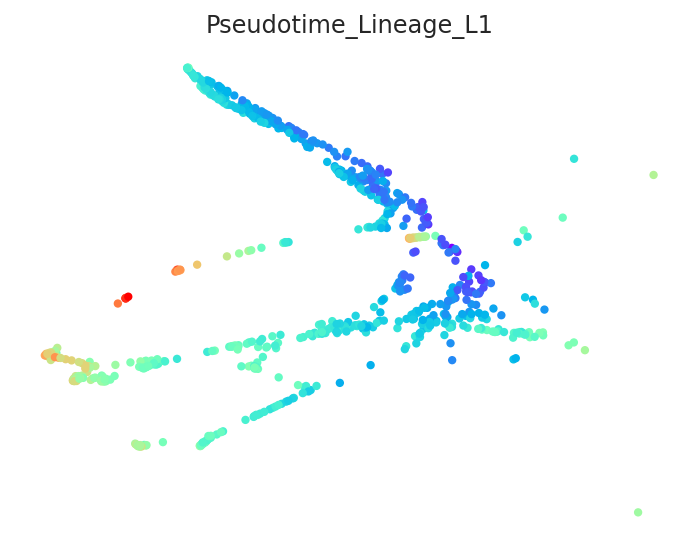

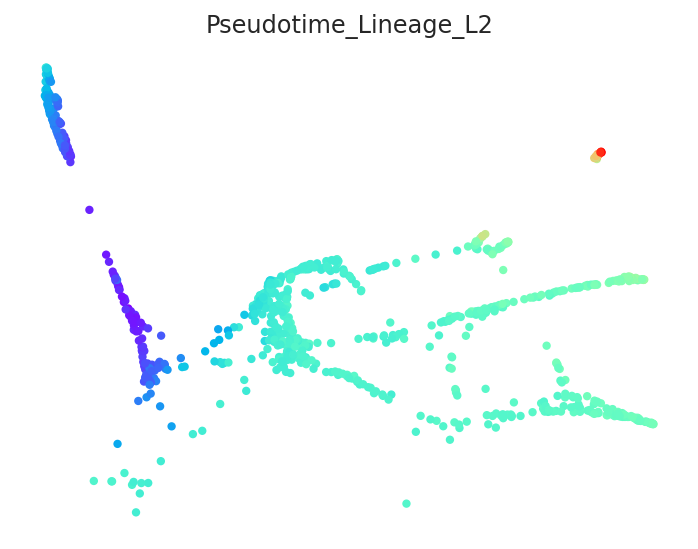

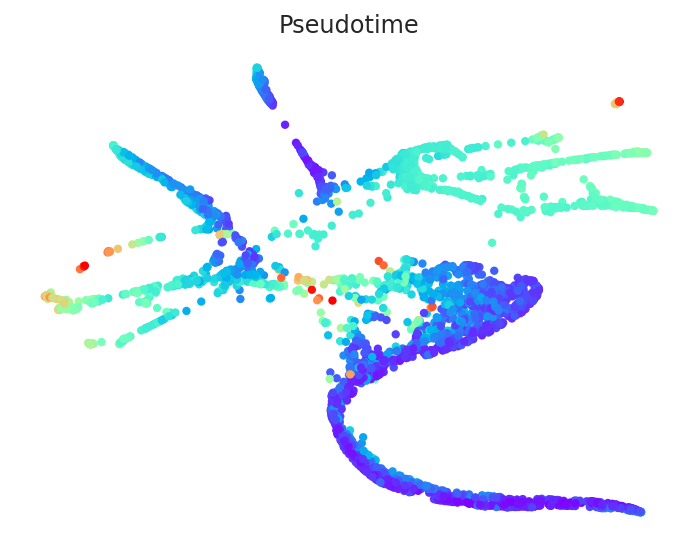

In [63]:
# Calculate pseudotime
pt.get_pseudotime_per_each_lineage()

# Check results
pt.plot_pseudotime(cmap="rainbow")
# Add calculated pseudotime data to the oracle object
oracle.adata.obs = pt.adata.obs

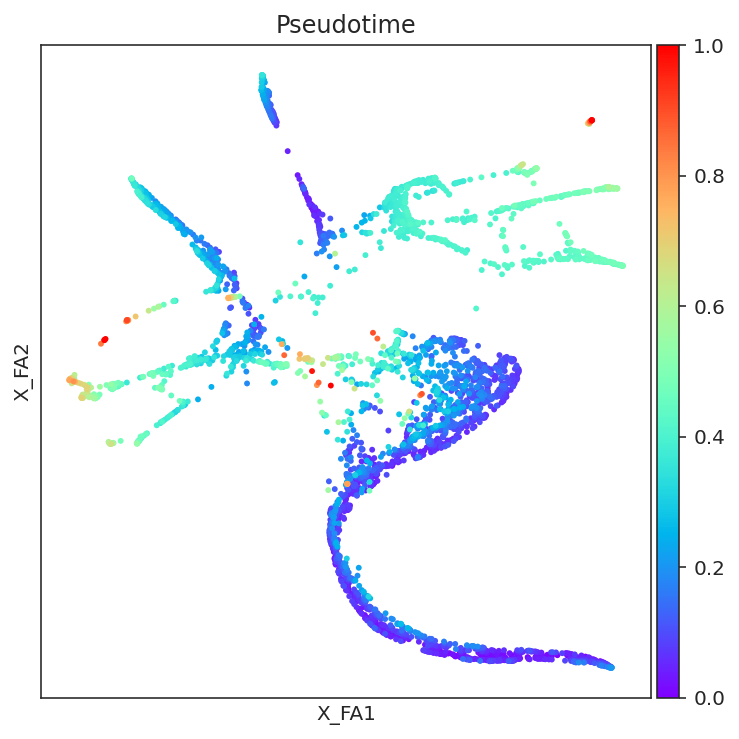

In [64]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["Pseudotime"])

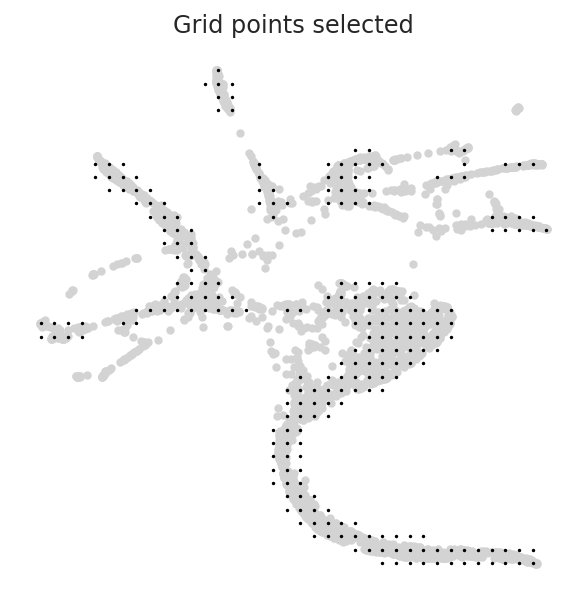

In [65]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)
gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})

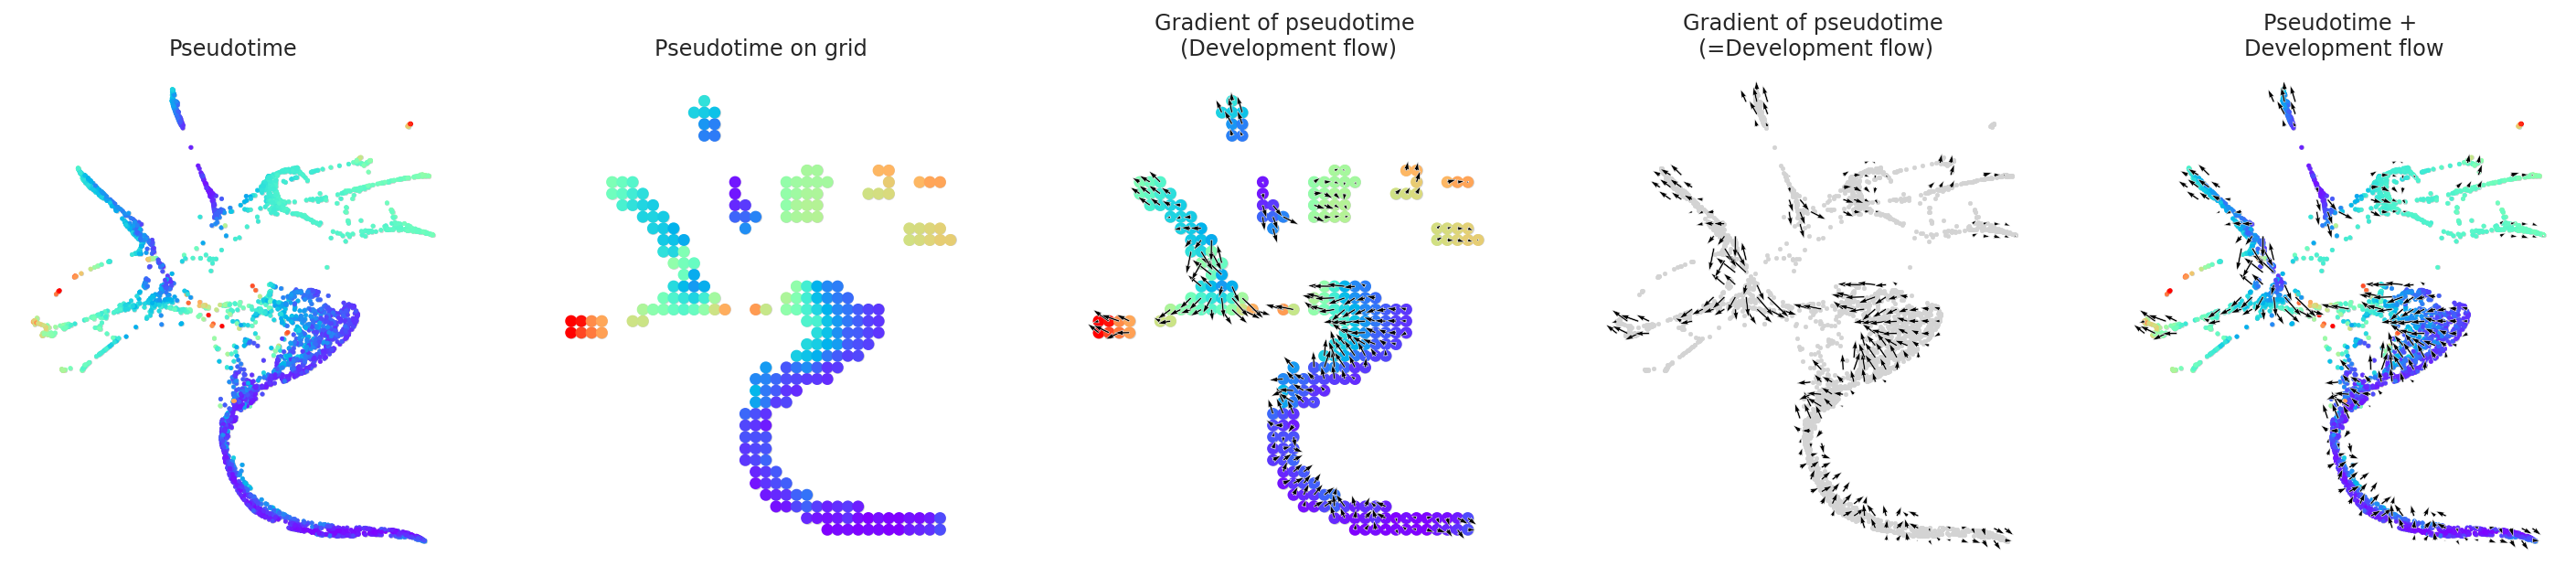

In [66]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

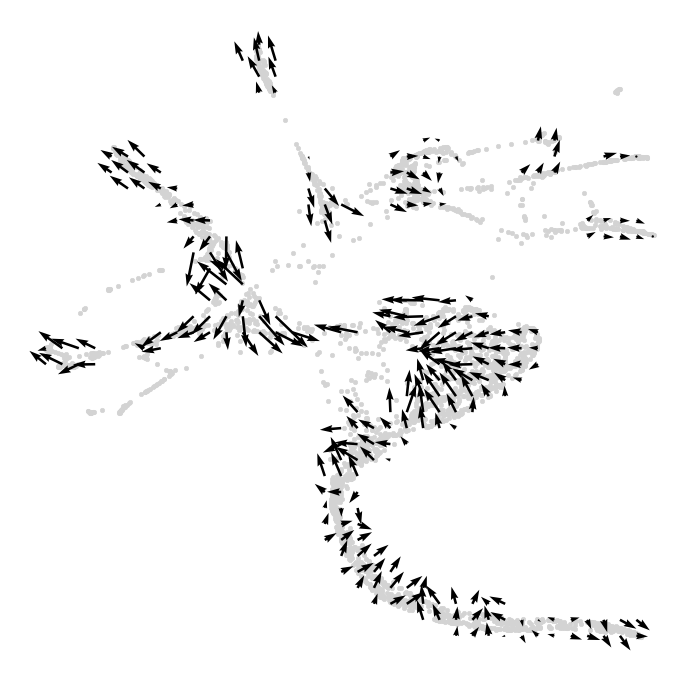

In [67]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [68]:
# Save gradient object if you want.
oracle_name = "Kannan_perinatal"
gradient.to_hdf5(file_path=f"{oracle_name}.celloracle.gradient")

In [69]:
from celloracle.applications import Oracle_development_module

In [70]:

# Make Oracle_development_module to compare two vector field
oracle = co.load_hdf5("intermedia_data.celloracle.oracle")
gradient = co.load_hdf5("Kannan_perinatal.celloracle.gradient")
dev = Oracle_development_module(gradient_object=gradient,oracle_object=oracle)
# # Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=5)


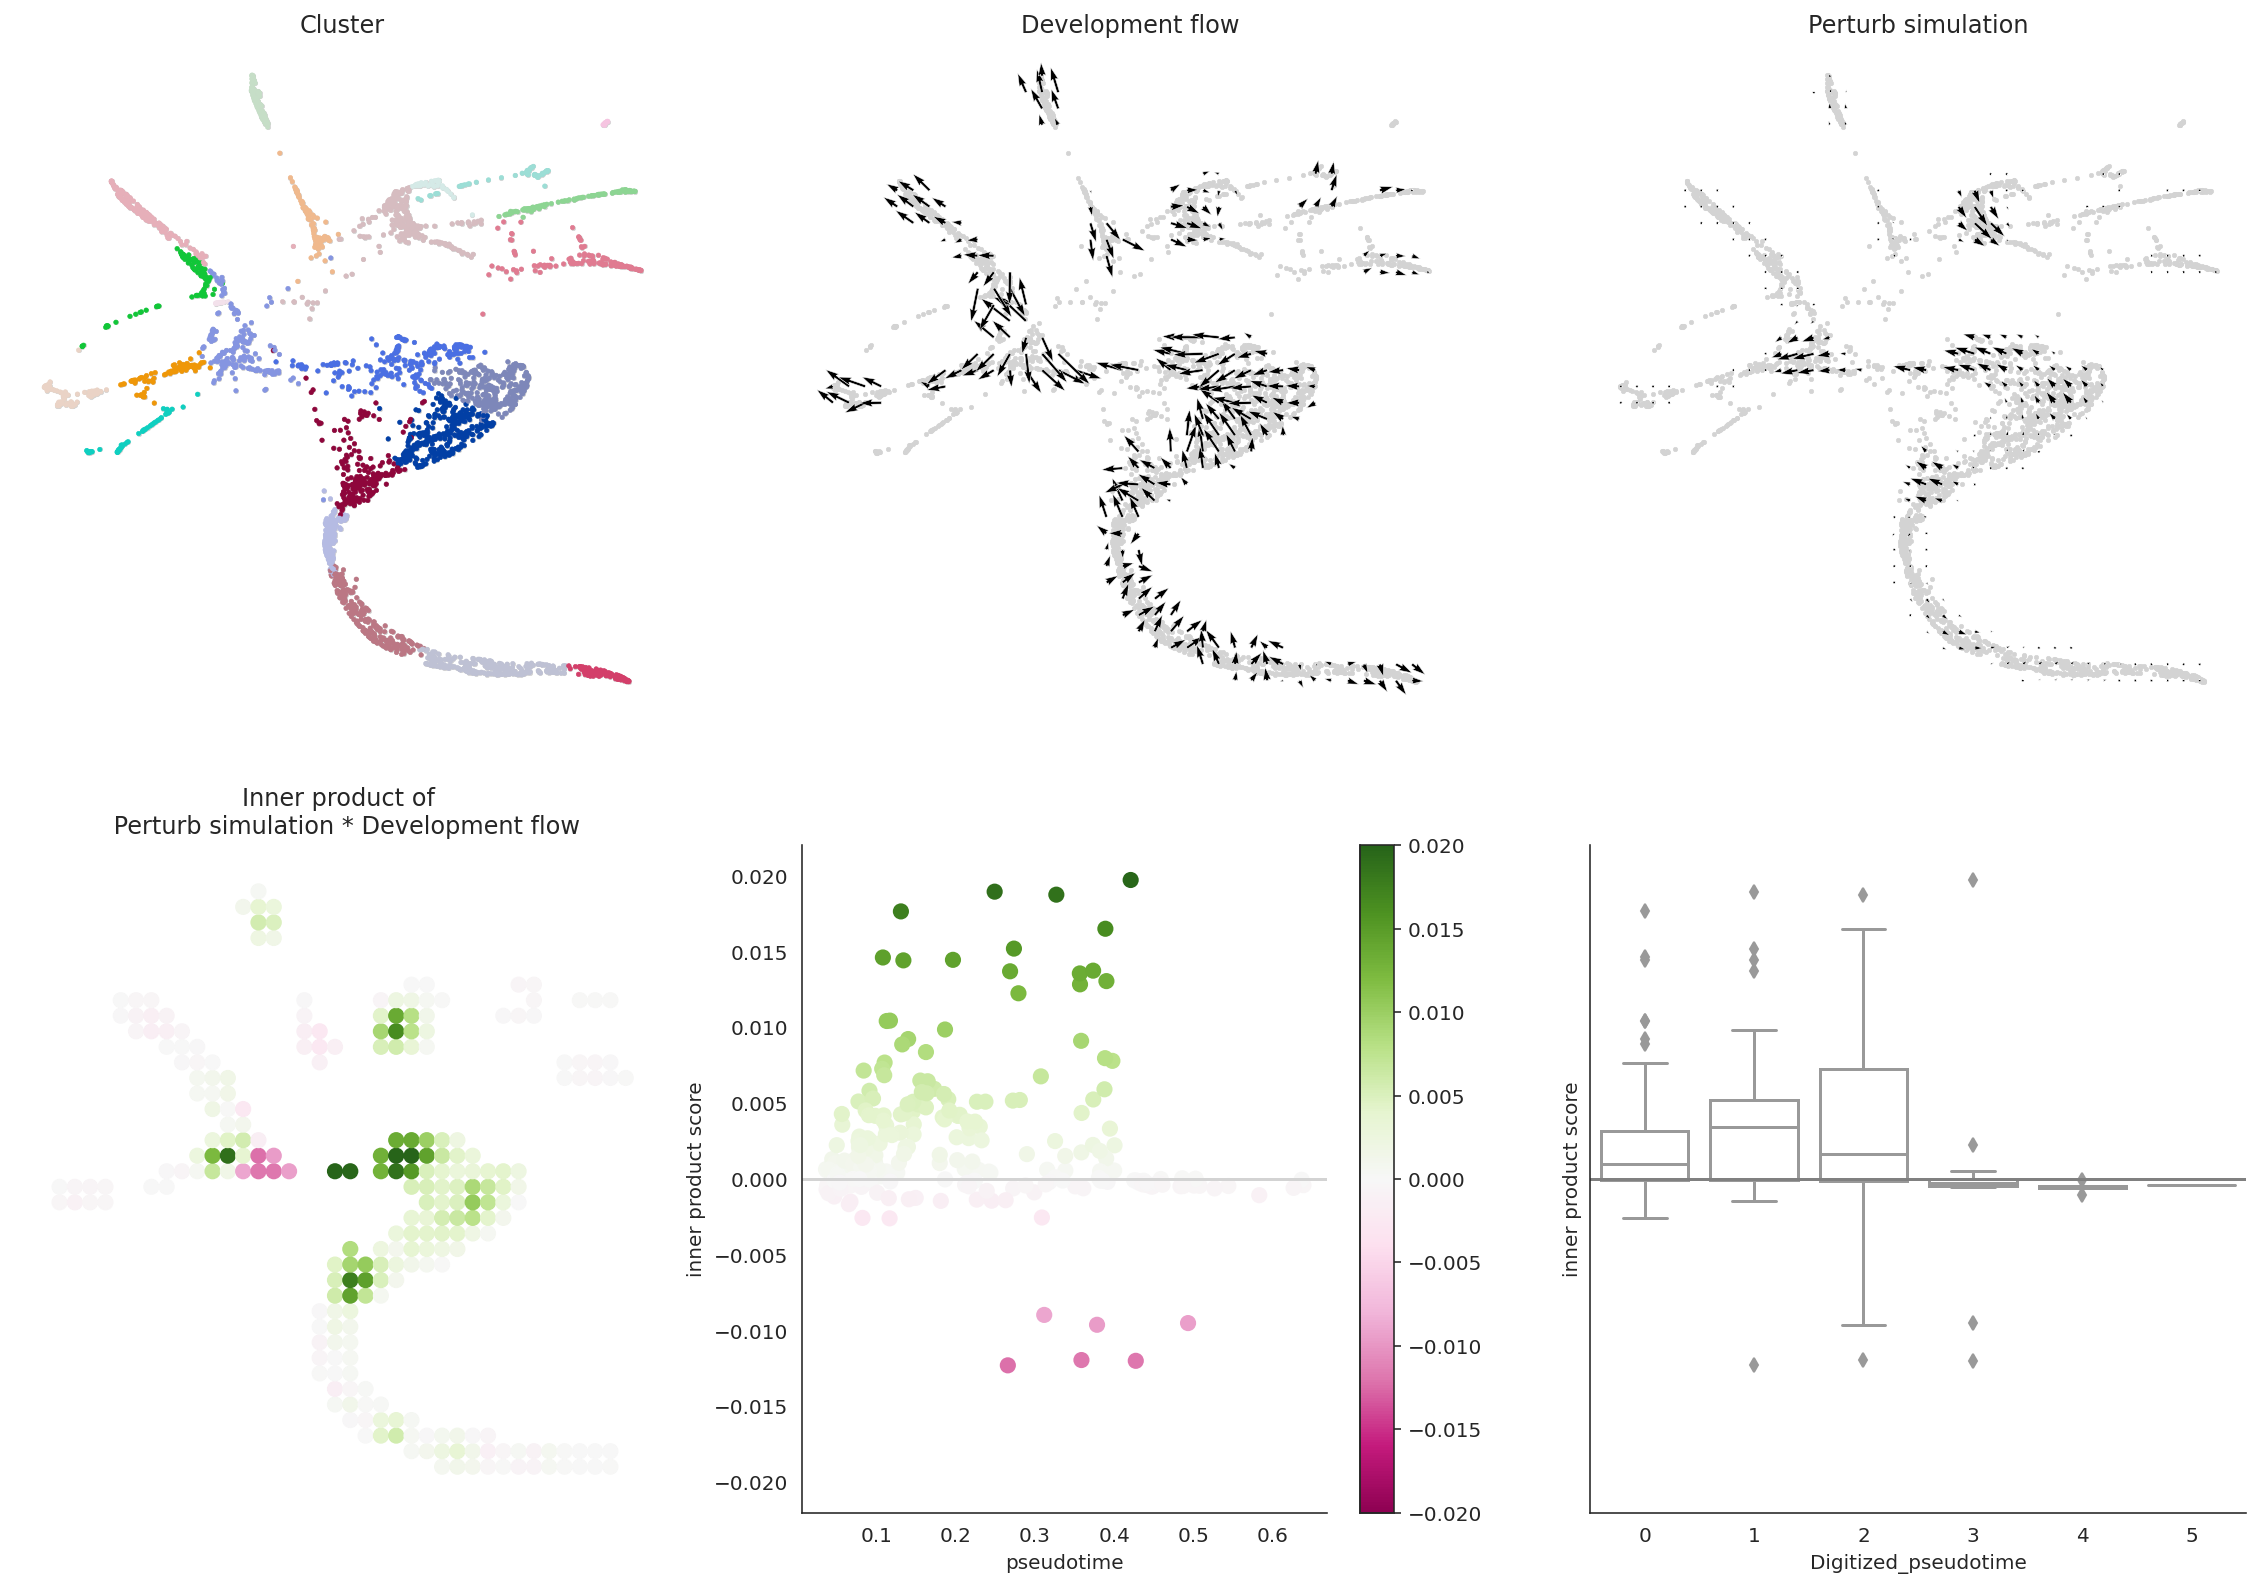

In [72]:
scale_simulation = 0.5
scale_dev = 40
# Let's visualize the results
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=0.02)
                                          